In [1]:
import os
import importlib
from timeit import timeit
import logging
import sys
import importlib
import time
import multiprocessing as mp
import multiprocessing.pool

import numpy as np
print("test5")
import pandas as pd
import scipy
import h5py
import matplotlib
from matplotlib import pyplot as plt
# import seaborn as sns
import numba
import sklearn.linear_model

from ion_networks import ms_utils
from ion_networks import browser
from ion_networks import interface
from ion_networks import ms_database
from ion_networks import ms_run_files

import sandbox

# import line_profiler
# profile = line_profiler.LineProfiler()
# heat.evolve = profile(heat.evolve)
# profile.print_stats()

def reload():
    importlib.reload(ms_run_files)
    importlib.reload(ms_utils)
    importlib.reload(browser)
    importlib.reload(interface)
    importlib.reload(sandbox)
    importlib.reload(ms_database)
   

test5


In [ ]:
import pyteomics
import pyteomics.mass
peptide = "PEPTIDER"

for i in range(1, len(peptide)):
    print( peptide[:i], pyteomics.mass.fast_mass(
            peptide[:i], ion_type="b", charge=1))
    print( peptide[i:], pyteomics.mass.fast_mass(
            peptide[i:], ion_type="y", charge=1))

In [3]:
reload()
self = ms_run_files.HDF_Evidence_File("/Users/swillems/Data/ion_networks/ecoli/28Oct2016_060.inet.hdf")
other = ms_run_files.HDF_Evidence_File("/Users/swillems/Data/ion_networks/ecoli/28Oct2016_061.inet.hdf")
inet1 = self.ion_network
inet2 = other.ion_network
fint1, fmz1, pmz1, prt1 = inet1.get_ion_coordinates()
fint2, fmz2, pmz2, prt2 = inet2.get_ion_coordinates()
parameters = {
    "log_file_name": "log.txt",
    "output_directory": "",
    "force_overwrite": True,
    "threads": 8,
    "fragment_errors": {
        "FRAGMENT_MZ": 50.0,
        "PRECURSOR_RT": 0.5,
        "PRECURSOR_DT": 2.0,
        "PRECURSOR_MZ": 5.0
    },
    "calibrate_PRECURSOR_RT": True,
    "calibration_ppm_FRAGMENT_MZ": 1.0,
    "calibration_ions": 50000
}
inet1.dimensions

['FRAGMENT_LOGINT', 'FRAGMENT_MZ', 'PRECURSOR_DT', 'PRECURSOR_RT']

In [4]:
ali1_unique = self.get_nodes(
    other=other,
    return_as_mask=False,
    kind="unique",
)
ali2_unique = other.get_nodes(
    other=self,
    return_as_mask=False,
    kind="unique",
)

ali1_ambiguous = self.get_nodes(
    other=other,
    return_as_mask=False,
    kind="ambiguous",
)
ali2_ambiguous = other.get_nodes(
    other=self,
    return_as_mask=False,
    kind="ambiguous",
)

In [5]:
self_indices = np.concatenate([ali1_unique, ali1_ambiguous])
other_indices = np.concatenate([ali2_unique, ali2_ambiguous])
fmzs = (np.abs(fmz1[self_indices] - fmz2[other_indices]))* 10**6 / fmz1[self_indices]
prts = np.abs(prt1[self_indices] - prt2[other_indices])
pmzs = np.abs(pmz1[self_indices] - pmz2[other_indices])

In [ ]:
# %matplotlib notebook

# plt.scatter(
#     fmz1[self_indices],
#     fmz2[other_indices],
# )

In [6]:
selection = ...
# selection = order[:np.argmax(counts)]
self_unique = np.bincount(self_indices[selection]) == 1
other_unique = np.bincount(other_indices[selection]) == 1
unique = self_unique[self_indices[selection]] & other_unique[other_indices[selection]]
np.bincount(unique), #pmzs[order[np.argmax(counts)]]

(array([175081, 443441]),)

In [7]:
@numba.njit
def get_unique_apex_and_count(
    ordered_self_indices,
    ordered_other_indices,
    return_all_counts=True
):
    counts = np.zeros_like(ordered_self_indices)
    self_max = np.max(ordered_self_indices)
    other_max = np.max(ordered_other_indices)
    unique_pair = np.zeros(counts.shape[0], np.bool_)
    self_frequencies = np.zeros(self_max + 1, np.int64)
    other_frequencies = np.zeros(other_max + 1, np.int64)
    self_indptr = np.empty(self_max + 2, np.int64)
    self_indptr[0] = 0
    self_indptr[1:] = np.cumsum(np.bincount(ordered_self_indices))
    self_order = np.argsort(ordered_self_indices)
    other_indptr = np.empty(other_max + 2, np.int64)
    other_indptr[0] = 0
    other_indptr[1:] = np.cumsum(np.bincount(ordered_other_indices))
    other_order = np.argsort(ordered_other_indices)
    unique_count = 0
    max_count = 0
    apex = 0
    for i in range(counts.shape[0]):
        self_index = ordered_self_indices[i]
        other_index = ordered_other_indices[i]
        if (self_frequencies[self_index] == 0) & (other_frequencies[other_index] == 0):
            unique_count += 1
            unique_pair[i] = True
            if unique_count > max_count:
                apex = i
                max_count = unique_count
        else:
            self_locs = self_order[self_indptr[self_index]: self_indptr[self_index + 1]]
            if np.any(unique_pair[self_locs]):
                unique_count -= 1
            other_locs = other_order[other_indptr[other_index]: other_indptr[other_index + 1]]
            if np.any(unique_pair[other_locs]):
                unique_count -= 1
            unique_pair[self_locs] = False
            unique_pair[other_locs] = False
        self_frequencies[self_index] += 1
        other_frequencies[other_index] += 1
        counts[i] = unique_count
    if not return_all_counts:
        counts = counts[apex: apex + 1]
    return apex, counts

<IPython.core.display.Javascript object>


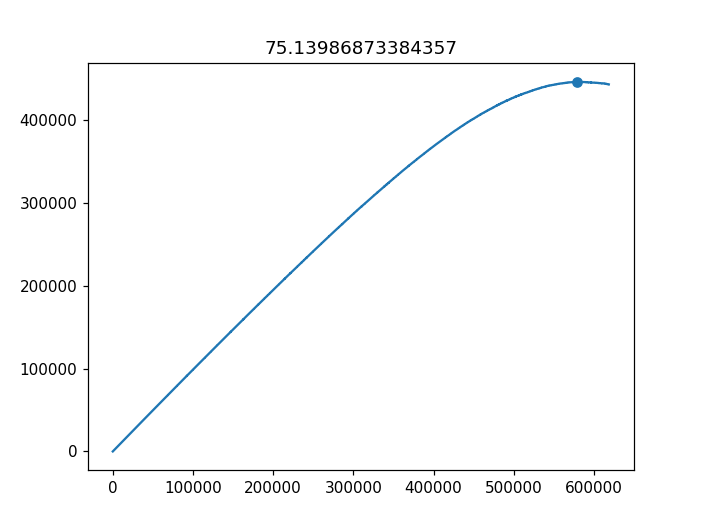

Text(0.5, 1.0, '75.13986873384357')

In [8]:
%matplotlib notebook

array = fmzs
order = np.argsort(array)

apex, counts = get_unique_apex_and_count(
    self_indices[order],
    other_indices[order],
    return_all_counts=True
)

max_value = array[order[apex]]

plt.plot(counts)
plt.scatter(apex, counts[apex])
plt.title(max_value)

In [ ]:
%timeit get_unique_apex_and_count(self_indices[order],other_indices[order])

In [ ]:
%matplotlib notebook

arr = prts

plt.plot(
    np.percentile(arr[unique], range(101))
)
plt.plot(
    np.percentile(arr[~unique], range(101))
)
# plt.plot(
#     np.percentile(prts, range(101))
# )

In [10]:
reload()

inets = []
evis = []
anis = []
# in_folder = "/home/sander/Documents/Proteomics/data/ion_networks"
in_folder = "/Users/swillems/Data/ion_networks/ecoli"
# in_folder = "/home/sander/Documents/Proteomics/data/jpt/APEX"
for file_name in ms_utils.get_file_names_with_extension([in_folder], ".inet.hdf"):
    inets.append(
        ms_run_files.HDF_Network_File(
            file_name
        )
    )
    evis.append(
        ms_run_files.HDF_Evidence_File(
            file_name
        )
    )
#     anis.append(
#         ms_run_files.HDF_Annotation_File(
#             file_name
#         )
#     )

In [ ]:
ani_indices = anis[0].get_dataset("indices", 'edge_candidates')
ani_indptr = anis[0].get_dataset("indptr", 'edge_candidates')

In [ ]:
anis[0].get_dataset

In [19]:
other_evi.run_name

'28Oct2016_061'

In [23]:
self_inet = inets[0]
self_evi = evis[0]
other_inet = inets[1]
other_evi = evis[1]

self_alignment = self_evi.get_nodes(
    other_evi,
    return_as_mask=False
)
other_alignment = other_evi.get_nodes(
    self_evi,
    return_as_mask=False
)
# other_logints = inets[other_name].get_ion_coordinates(
#     "FRAGMENT_LOGINT",
#     indices=other_alignment
# )
# logints[i, self_alignment] = other_logints

<IPython.core.display.Javascript object>


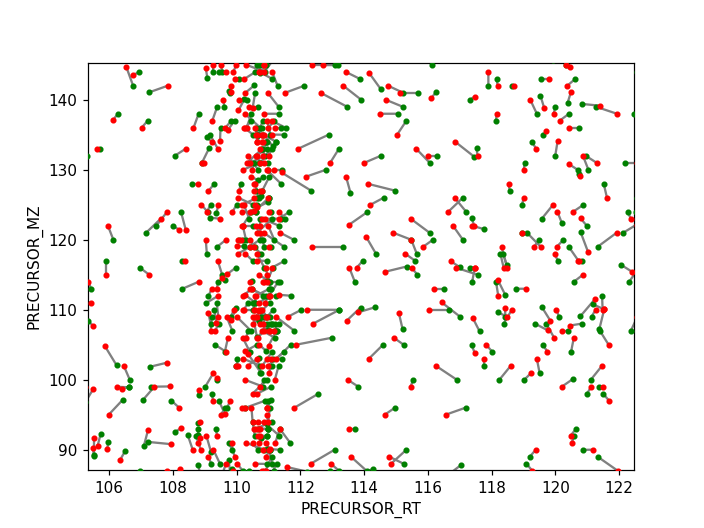

Text(0, 0.5, 'PRECURSOR_MZ')

In [25]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)

ind_start = 0
ind_size = len(self_alignment)

a1 = self_inet.get_ion_coordinates("PRECURSOR_RT", indices = self_alignment[ind_start: ind_start+ind_size])
b1 = self_inet.get_ion_coordinates("PRECURSOR_DT", indices = self_alignment[ind_start: ind_start+ind_size])
a2 = other_inet.get_ion_coordinates("PRECURSOR_RT", indices = other_alignment[ind_start: ind_start+ind_size])
b2 = other_inet.get_ion_coordinates("PRECURSOR_DT", indices = other_alignment[ind_start: ind_start+ind_size])

# ax=

start_edges = list(zip(a1, b1))
end_edges = list(zip(a2, b2))
# colors = positive_counts[selection] - negative_counts[selection]
edges = np.array(list(zip(start_edges, end_edges)))

x = ax.add_collection(
    matplotlib.collections.LineCollection(edges),
)
x.set_color("grey")
ax.scatter(a1, b1, marker=".", c="g", zorder=10)
ax.scatter(a2, b2, marker=".", c="r", zorder=10)
ax.set_xlabel("PRECURSOR_RT")
ax.set_ylabel("PRECURSOR_MZ")
# sns.jointplot(a1[ind_start: ind_start+ind_size], a2[ind_start: ind_start+ind_size], kind="kde",gridsize=100)

In [14]:
import matplotlib
sorted(matplotlib.colors.__dict__['CSS4_COLORS'])

['aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 

In [ ]:
# repro = evi.get_aligned_nodes_from_group()

['FRAGMENT_LOGINT', 'FRAGMENT_MZ', 'PRECURSOR_DT', 'PRECURSOR_RT']


<IPython.core.display.Javascript object>


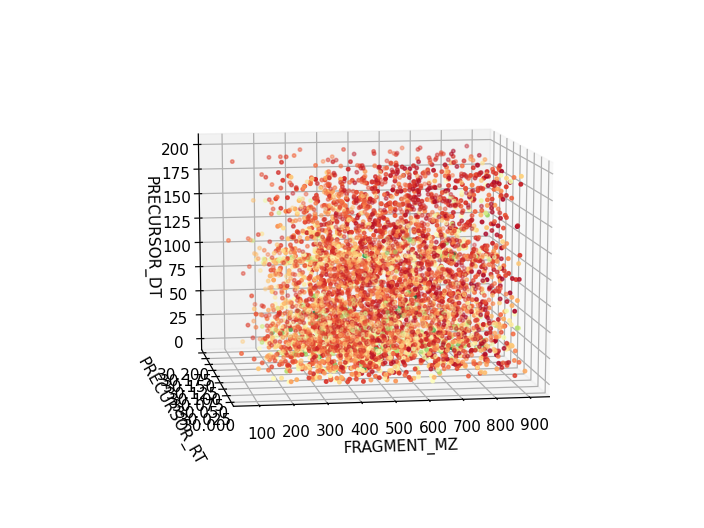

Text(0.5, 0, 'PRECURSOR_DT')

In [15]:
inet=inets[0]
evi=evis[0]

%matplotlib notebook
coords = inet.get_ion_coordinates(inet2.dimensions)
print(inet.dimensions)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# repro = evi.get_aligned_nodes_from_group()

selection = (coords[3] > 30) & (coords[3] < 30.2)
selection &= (coords[2] < 2000)
selection &= (coords[1] < 900)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
ax.scatter(
    coords[1][selection],
    coords[3][selection],
    coords[2][selection],
    marker=".",
    c=coords[0][selection],
    cmap="RdYlGn"
)
ax.set_xlabel(inet.dimensions[1])
ax.set_ylabel(inet.dimensions[3])
ax.set_zlabel(inet.dimensions[2])

In [ ]:
reload()

an = annotation.Annotation(
    evidence=evis[0],
    database="/home/sander/Documents/Proteomics/data/databases/hdf/crap_ecoli_concatenated_decoy.hdf",
    parameters={
        "annotation_ppm": 20,
    },
    logger=logger
)

In [ ]:
self=inets[1]
# indptr, indices = self.get_edges(
#     indptr_and_indices=True
# )
# x, y = self.get_edges(return_as_scipy_csr=False)

In [ ]:
rts = self.get_ion_coordinates("PRECURSOR_RT")
rts[:1000000]

In [ ]:
reload()

self = inets[0]
other = inets[1]
# self_ints, self_mzs, self_pmzs, self_rts = self.get_ion_coordinates()
# other_ints, other_mzs, other_pmzs, other_rts = other.get_ion_coordinates()
# calibrated_self_rts = sandbox.calibrate_precursor_rt(self, other, ppm=10)

In [ ]:
self_mzs = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_01_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_MZ"]
).values.flatten()
other_mzs = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_08_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_MZ"]
).values.flatten()

self_logints = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_01_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_LOGINT"]
).values.flatten()
other_logints = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_08_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_LOGINT"]
).values.flatten()

In [ ]:
# le_indices = np.concatenate(
#     [
#         start + np.argpartition(
#             ions["INTENSITY"][start: end], - to_select_per_sample
#         )[-to_select_per_sample:] for start, end in zip(
#             start_indices[:-1],
#             start_indices[1:]
#         )
#     ]
# )


In [ ]:
calibration_ions = 50000
self_ions = np.argpartition(self_logints, -calibration_ions)[-calibration_ions:]
other_ions = np.argpartition(other_logints, -calibration_ions)[-calibration_ions:]

In [ ]:
self_mzs = self_mzs[self_ions]
other_mzs = other_mzs[other_ions]

In [ ]:
np.sort(self_mzs), np.sort(other_mzs)

In [ ]:
self_mzs = self.get_ion_coordinates("FRAGMENT_MZ")
other_mzs = other.get_ion_coordinates("FRAGMENT_MZ")
# self_indices, other_indices = sandbox.quick_align(self_mzs, other_mzs, ppm=10)
# self_rts = self.get_ion_coordinates("PRECURSOR_RT")
# other_rts = other.get_ion_coordinates("PRECURSOR_RT", indices=other_indices)

In [ ]:
self_inds = np.repeat(0, len(self_mzs))
other_inds = np.repeat(1, len(other_mzs))

In [ ]:
mzs = np.concatenate([self_mzs, other_mzs])
inds = np.concatenate([self_inds, other_inds])
order = np.argsort(mzs)
mzs = mzs[order]
inds = inds[order]

In [ ]:
mz_diffs = np.diff(mzs)
ind_diffs = np.diff(inds)
x = np.concatenate([mz_diffs[ind_diffs==1], -mz_diffs[ind_diffs==-1]])

In [ ]:
x = (mz_diffs[:-2] < mz_diffs[1:-1]) & (mz_diffs[1:-1] < mz_diffs[2:])
x &= ind_diffs[1:-1] != 0
x = mz_diffs[1:-1][x] * -ind_diffs[1:-1][x]

In [ ]:
np.quantile(
    mz_diffs[ind_diffs==-1] * 10**6 / mzs[:-1][ind_diffs==-1],
    0.5
)

In [ ]:
%matplotlib notebook

# s = np.concatenate([mz_diffs[ind_diffs==1], -mz_diffs[ind_diffs==-1]])

plt.scatter(
    mzs[:-1][ind_diffs==1],
    mz_diffs[ind_diffs==1] * 10**6 / mzs[:-1][ind_diffs==1]
#     np.sort(self_mzs),
#     np.sort(other_mzs) - np.sort(self_mzs),
#     10**6 * (np.sort(self_mzs) - np.sort(other_mzs)) / np.sort(self_mzs)
)

In [ ]:
%matplotlib notebook

a, b = np.unique(np.round(x,3), return_counts=True)
print(np.quantile(x, np.arange(101)/100), np.median(x))
# plt.plot(a,b)
plt.plot(np.quantile(x, np.arange(101)/100))

In [ ]:
new_self_rts = []
for self_start_index, self_end_index, other_rt_start, other_rt_end in zip(
    self_indices[:-1],
    self_indices[1:],
    other_rts[:-1],
    other_rts[1:]
):
#     if self_end_index == self_start_index:
#         continue
    self_rt_start = self_rts[self_start_index]
    self_rt_end = self_rts[self_end_index]
    if self_rt_start == self_rt_end:
        new_rts = np.repeat(other_rt_start, self_end_index - self_start_index)
    else:
        slope = (other_rt_end - other_rt_start) / (self_rt_end - self_rt_start)
        new_rts = other_rt_start + slope * (
            self_rts[self_start_index: self_end_index] - self_rt_start
        )
    new_self_rts.append(new_rts)
new_self_rts.append([other_rts[-1]])
new_self_rts = np.concatenate(new_self_rts)

In [ ]:
new_self_rts.shape[0] - self_rts.shape[0]

In [ ]:
self_rts = self.get_ion_coordinates("PRECURSOR_RT")

In [ ]:
%matplotlib notebook

plt.scatter(self_rts, self_rts - calibrated_self_rts)

In [ ]:
reload()

self_ints, self_mzs, self_dts, self_rts = self.get_ion_coordinates()
other_ints, other_mzs, other_dts, other_rts = other.get_ion_coordinates()
self_indices, other_indices = sandbox.quick_align(self_mzs, other_mzs, ppm=10)

In [ ]:
# s = slice(0, None, 1000)
a1 = self_rts[self_indices]
a2 = other_rts[other_indices]
c = self_dts[self_indices] - other_dts[other_indices]

In [ ]:
ppm=10

self_mz_order = np.argsort(self_mzs)
other_mz_order = np.argsort(other_mzs)
max_mz_diff = 1 + ppm * 10**-6
low_limits = np.searchsorted(
    self_mzs[self_mz_order],
    other_mzs[other_mz_order] / max_mz_diff,
    "left"
)
high_limits = np.searchsorted(
    self_mzs[self_mz_order],
    other_mzs[other_mz_order] * max_mz_diff,
    "right"
)
other_rt_order = np.argsort(other_mz_order)
self_indices = np.concatenate(
    [
        self_mz_order[l:h] for l, h in zip(
            low_limits[other_rt_order],
            high_limits[other_rt_order]
        )
    ]
)
other_indices = np.repeat(
    np.arange(len(other_rt_order)),
    high_limits[other_rt_order] - low_limits[other_rt_order]
)

In [ ]:
%matplotlib notebook

plt.plot(a1, a2)

In [ ]:
%matplotlib notebook

# plt.plot(a1, a2)
# plt.scatter(a1, a2, marker=".", c=c, cmap="RdYlGn")
# sns.jointplot(a1, a2, kind="hex", gridsize=200)
# sns.jointplot(self_rts[self_indices], other_rts[other_indices], kind="hex", gridsize=100)
plt.scatter(self_rts[self_indices], other_rts[other_indices], marker=".")

In [ ]:
%matplotlib notebook

a,b=np.unique(np.round(c,0), return_counts=True)
plt.plot(a,b)

In [ ]:
self_rts = self.get_ion_coordinates("PRECURSOR_RT")
other_rts = other.get_ion_coordinates("PRECURSOR_RT", indices=other_indices)
new_self_rts = []
for self_start_index, self_end_index, other_rt_start, other_rt_end in zip(
    self_indices[:-1],
    self_indices[1:],
    other_rts[:-1],
    other_rts[1:]
):
    self_rt_start = self_rts[self_start_index]
    self_rt_end = self_rts[self_end_index]
    if self_rt_start == self_rt_end:
        new_rts = np.repeat(other_rt_start, self_end_index - self_start_index)
    else:
        slope = (other_rt_end - other_rt_start) / (self_rt_end - self_rt_start)
        new_rts = other_rt_start + slope * (
            self_rts[self_start_index: self_end_index] - self_rt_start
        )
    new_self_rts.append(new_rts)
new_self_rts.append([other_rts[-1]])
new_self_rts = np.concatenate(new_self_rts)

In [ ]:
# %matplotlib notebook

# s = slice(0, None, 1000)
# plt.scatter(new_self_rts[s], self_rts[s])

In [ ]:
ints, mzs, pmzs, rts = inets[0].get_ion_coordinates()

In [ ]:
reload()

ali = evis[0].get_alignment(evis[1])
# pairwise_alignment = inets[0].align_nodes(
#     inets[1],
#     parameters
# )
# ali = [
#     pairwise_alignment.T.tocsr().indices,
#     pairwise_alignment.indices
# ]
# a = np.repeat(np.arange(pairwise_alignment.shape[0]), np.diff(pairwise_alignment.indptr))
# aa = pairwise_alignment.nonzero()[0]
# a,aa,np.bincount(a==aa)

In [ ]:
def rt_diffs(isotopic_distance, ppm, rts):
    mz_order = np.argsort(mzs)
    mzs_in_mz_order = mzs[mz_order]
    if isotopic_distance > 0:
        lower_limits = np.searchsorted(
            mzs_in_mz_order,
            (mzs_in_mz_order + isotopic_distance) / (1 + ppm * 10**-6),
            "left"
        )
    else:
        lower_limits = np.arange(len(mzs)) + 1
    upper_limits = np.searchsorted(
        mzs_in_mz_order,
        (mzs_in_mz_order + isotopic_distance) * (1 + ppm * 10**-6),
        "right"
    )
    first_isotopic_pairs = np.repeat(mz_order, upper_limits - lower_limits)
    second_isotopic_pairs = np.concatenate([mz_order[l: u] for u, l in zip(upper_limits, lower_limits)])
    return np.abs(rts[first_isotopic_pairs] - rts[second_isotopic_pairs])

In [ ]:
isotopic_rts = rt_diffs(isotopic_distance = 1.002, ppm=2, rts=rts)
random_rts = rt_diffs(isotopic_distance = 3.8254, ppm=2, rts=rts)

In [ ]:
all_rts = np.concatenate([isotopic_rts, random_rts])
all_labels = np.repeat([False, True], [len(isotopic_rts), len(random_rts)])
order = np.argsort(all_rts)
all_rts = all_rts[order]
all_labels = all_labels[order]
fdr = np.cumsum(all_labels) / (1 + np.arange(len(all_labels)))

In [ ]:
np.argmin(fdr)

In [ ]:
%matplotlib notebook

s = slice(0,10000000, 1)
plt.plot(all_rts[s], fdr[s])

In [ ]:
isotope_rt_diffs, isotope_count = np.unique(
        isotopic_rts,
        return_counts=True
    )
isotope_count = np.cumsum(isotope_count)
random_rt_diffs, random_count = np.unique(
        random_rts,
        return_counts=True
    )
random_count = np.cumsum(random_count)

In [ ]:
# random_diffs = isotope_rt_diffs
# random_counts = isotope_count

In [ ]:
%matplotlib notebook

# plt.plot(
#     *np.unique(
#         np.round(
#             rts[first_isotopic_pairs] - rts[second_isotopic_pairs],
#             3
#         ),
#         return_counts=True
#     )
# )


plt.plot(
    isotope_rt_diffs, isotope_count/isotope_count[-1]
)
plt.plot(
    random_rt_diffs, random_count/random_count[-1]
)
# plt.plot(
#     random_diffs, random_counts/random_counts[-1]+0.0029-0.001, c="r"
# )
# plt.plot(
#     random_diffs, random_counts/random_counts[-1]+0.0029+0.0015, c="r"
# )
# plt.plot(
#     random_diffs, random_counts/random_counts[-1], c="r"
# )
plt.axhline(0.5, c="grey")
plt.axvline(0, c="grey")
# plt.plot([-15,15], [0.313,0.69])

# plt.plot(
#     isotope_rt_diffs,
#     np.gradient(isotope_count),
# )

In [ ]:
%matplotlib notebook

ricos = np.diff(isotope_count) / np.diff(isotope_rt_diffs)
plt.plot(isotope_rt_diffs[:-1], ricos)

In [ ]:
%matplotlib notebook

sns.jointplot(
    rts[first_isotopic_pairs[::10]],
    rts[second_isotopic_pairs[::10]],
    kind="hex",
    gridsize=500
)

In [ ]:
%matplotlib notebook

sns.jointplot(
    inets[0].get_ion_coordinates("FRAGMENT_LOGINT", indices=ali[:,0]),
    inets[1].get_ion_coordinates("FRAGMENT_LOGINT", indices=ali[:,1]),
    kind="hex",
    gridsize=500
)

In [ ]:
left, right = inets[0].get_edges(return_as_scipy_csr=False)
mzs = inets[0].get_ion_coordinates("MZ2")
diffs2 = mzs[left] - mzs[right]

In [ ]:
z = evidences[0].get_evidence(network_keys=[k.key for k in inets[1:]], return_total=True)

In [ ]:
edges = inets[0].get_edges()
edges.data = z[0] > z[1] + 8
edges.eliminate_zeros()
left, right = edges.nonzero()
mzs = inets[0].get_ion_coordinates("MZ2")
diffs = mzs[left] - mzs[right]

In [ ]:
# ori_a, ori_b = np.unique(np.round(diffs2, 3), return_counts=True)
new_a, new_b = np.unique(np.round(diffs, 3), return_counts=True)

In [ ]:
%matplotlib notebook

plt.plot(ori_a, ori_b/np.max(ori_b))
plt.plot(new_a, new_b/np.max(new_b))

In [ ]:
mzs = inets[0].get_ion_coordinates("MZ2")
diffs = np.abs(mzs[left] - mzs[right])
good = np.abs(diffs - 1.002) < 0.01

In [ ]:
inets[0].get_ion_coordinates(indices=z[0])

In [ ]:
posi = z[0][good]
negi = z[1][good]
np.bincount(posi), np.bincount(negi)

In [ ]:
# iso = np.histogram2d(posi, negi, bins=10)[0].astype(np.int)
# total = np.histogram2d(z[0], z[1], bins=10)[0].astype(np.int)
iso, total

In [ ]:
%matplotlib notebook
# sns.heatmap(np.log(iso/total), cmap="RdYlGn")
sns.heatmap(np.log(iso + 1), cmap="RdYlGn")

In [ ]:
selected = (z[0] + z[1]) > 0
# np.unique(z[0][selected] / (z[0] + z[1])[selected], return_counts=True)
a, b = np.unique(z[0][selected]-z[1][selected], return_counts=True)

In [ ]:
%matplotlib notebook

plt.plot(a, b)

In [ ]:
%matplotlib notebook

first_mz2, first_rt1, first_mz1, first_logint = inets[0].get_ion_coordinates(["MZ2", "RT", "MZ1", "LOGINT"])
second_mz2, second_rt2, second_mz1, second_logint = inets[1].get_ion_coordinates(["MZ2", "RT", "MZ1", "LOGINT"])
a = al.get_alignment(inets[0], inets[1], return_as_scipy_csr=False)

sns.jointplot(first_mz1, first_mz2, kind="hex", gridsize=500)
sns.jointplot(first_logint[a[:,0]], second_logint[a[:,1]], kind="hex", gridsize=500)

In [ ]:
importlib.reload(network)
mzs, rts = inet.get_ion_coordinates(["MZ2", "RT"])
isotopic_distance = 1.002
ppm = 10

isotope_rt_diffs, isotope_count = network.determine_isotopic_rt_difference(
    mzs,
    rts,
    isotopic_distance,
    ppm
)

In [ ]:
# mz_order = np.argsort(mzs)
# mzs_in_mz_order = mzs[mz_order]
# print(mzs_in_mz_order, (mzs_in_mz_order + isotopic_distance) * (1 + ppm * 10**-6))
rts

In [ ]:
ratios = []
resolution = np.linspace(0,1,100)
lower_limits = np.arange(len(rts)) + 1
for limit in resolution:
    upper_limits = np.searchsorted(
        rts,
        rts + limit,
        "right"
    )
    total = np.sum(upper_limits-lower_limits)
    ratio = isotope_count[np.searchsorted(isotope_rt_diffs, limit, "right")] / total
    ratios.append(ratio)

In [ ]:
%matplotlib notebook

plt.plot(resolution, ratios)

In [ ]:
%matplotlib notebook


plt.plot(isotope_rt_diffs, isotope_count / isotope_count[-1])

In [ ]:
indptr, indices = inet.get_edge_indptr_and_indices()

In [ ]:
second_indices = np.repeat(np.arange(len(indptr) - 1), np.diff(indptr))

In [ ]:
%matplotlib notebook

mzs = inet.get_ion_coordinates("MZ2")
diffs = np.abs(mzs[indices]-mzs[second_indices])

plt.plot(*np.unique(np.round(diffs,2), return_counts=True))

# plt.scatter(mzs[pairs[:,0]], diffs, marker=".")
# mzds = mzs[pairs[:,0]] - mzs[pairs[:,1]]
# sns.jointplot(mzs[pairs[:,0]], mzs[pairs[:,0]]-mzs[pairs[:,1]], kind="hex", gridsize=100)

In [ ]:
importlib.reload(network)
# inet1 = network.Network(
#     "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/ion_networks/28Oct2016_060_Apex3DIons.hdf"
# )
inet2 = network.Network(
    "/home/sander/Documents/Proteomics/data/tmp.hdf"
)
# inet.logger=logger

In [ ]:
coords = inet2.get_ion_coordinates(inet2.dimensions)
print(inet2.dimensions)

In [ ]:
%matplotlib notebook

selection = (coords[3] > 30) & (coords[3] < 31)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
plt.scatter(coords[1][selection], coords[3][selection], marker=".", c=coords[0][selection], cmap="RdYlGn")

In [ ]:
inet2 = network.Network(
    "/home/sander/Documents/Sandbox/test.inet.hdf"
)
# inet2=inets[0]

%matplotlib notebook
coords = inet2.get_ion_coordinates(inet2.dimensions)
print(inet2.dimensions)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

selection = (coords[3] > 30) & (coords[3] < 30.2)
selection &= (coords[2] < 2000)
selection &= (coords[1] < 900)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
ax.scatter(
    coords[1][selection],
    coords[3][selection],
    coords[2][selection],
    marker=".",
    c=coords[0][selection],
    cmap="RdYlGn"
)
ax.set_xlabel(inet2.dimensions[1])
ax.set_ylabel(inet2.dimensions[3])
ax.set_zlabel(inet2.dimensions[2])

In [ ]:
%matplotlib notebook
coords = inet1.get_ion_coordinates(inet1.dimensions)
print(inet1.dimensions)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

selection = (coords[3] > 30) & (coords[3] < 31)
selection &= (coords[2] < 2000)
selection &= (coords[1] < 900)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
ax.scatter(
    coords[1][selection],
    coords[3][selection],
    coords[2][selection],
    marker=".",
    c=coords[0][selection],
    cmap="RdYlGn"
)
ax.set_xlabel('MZ1')
ax.set_ylabel('RT')
ax.set_zlabel('MZ2')

In [ ]:
importlib.reload(network)
importlib.reload(alignment)
inets = []
in_folder = "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/ion_networks"
for file_name in sorted(os.listdir(in_folder)):
    in_file_name = os.path.join(in_folder, file_name)
    inet = network.Network(
        in_file_name
    )
    inets.append(inet)
al = alignment.Alignment(
    "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/alignment/alignment.hdf"
#     "/home/sander/Documents/Proteomics/data/ion_networks/dda/dda_sonar_test_align.hdf"
)

In [ ]:
importlib.reload(alignment)
al = alignment.Alignment(
    "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/alignment/alignment.hdf"
#     "/home/sander/Documents/Proteomics/data/ion_networks/dda/dda_sonar_test_align.hdf"
)

In [ ]:
%matplotlib notebook

# inets = [
#     network.Network("/home/sander/Documents/Proteomics/data/ion_networks/dda/tmp.hdf"),
#     network.Network("/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/ion_networks/28Oct2016_060_Apex3DIons.hdf")
# ]
i = 0
j = 1
dimension = "LOGINT"

x1, x2, x3, x4 = al.get_alignment(inets[i], inets[j])
array1 = inets[i].get_ion_coordinates(dimension)[x1]
array2 = inets[j].get_ion_coordinates(dimension)[x2]

# plt.scatter(array1, array2, marker=".")
sns.jointplot(array1, array2, kind="hex", gridsize=500)

In [ ]:
import sandbox
importlib.reload(sandbox)
edges1, edges2, ali = sandbox.align_edges(inets[0], inets[1], al)
edges1, edges2, ali

In [ ]:
indirect = (ali.T * edges1 * ali).tocsr()

In [ ]:
positive = indirect.multiply(edges2)

In [ ]:
available = edges2 * ali.T * ali

In [ ]:
negative = available - positive

In [ ]:
edges2, indirect, available, positive, negative

In [ ]:
mzs = inets[1].get_ion_coordinates("MZ2")

In [ ]:
%matplotlib notebook

first_indices, second_indices = edges2.nonzero()
diffs = np.abs(mzs[first_indices]-mzs[second_indices])
a, b = np.unique(np.round(diffs,2), return_counts=True)

plt.plot(a, b / np.average(b))

first_indices, second_indices = negative.nonzero()
diffs = np.abs(mzs[first_indices]-mzs[second_indices])
a, b = np.unique(np.round(diffs,2), return_counts=True)

plt.plot(a, b / np.average(b))

first_indices, second_indices = positive.nonzero()
diffs = np.abs(mzs[first_indices]-mzs[second_indices])
a, b = np.unique(np.round(diffs,2), return_counts=True)

plt.plot(a, b / np.average(b))

In [ ]:
np.unique(positive.data)

In [ ]:
inets[0].node_count

In [ ]:
posi = evis[0].get_edge_mask_from_group()
negi = evis[0].get_edge_mask_from_group(positive=False)

In [ ]:
first, second = evis[0].ion_network.get_edges().nonzero()

In [ ]:
posis = (posi == 9) & (negi == 0)
negis = (posi == 0) & (negi == 9)

In [ ]:
first_posi = first[posis]
second_posi = second[posis]
first_negi = first[negis]
second_negi = second[negis]

In [ ]:
posi_rtd = rts[second_posi] - rts[first_posi]
negi_rtd = rts[second_negi] - rts[first_negi]

In [ ]:
posi_rt_diffs, posi_count = np.unique(
        posi_rtd,
        return_counts=True
    )
posi_count = np.cumsum(posi_count)
negi_rt_diffs, negi_count = np.unique(
        negi_rtd,
        return_counts=True
    )
negi_count = np.cumsum(negi_count)

In [ ]:
%matplotlib notebook

plt.plot(
    posi_rt_diffs, posi_count / posi_count[-1]
)
plt.plot(
    negi_rt_diffs, negi_count / negi_count[-1]
)

In [ ]:
import numpy as np
a = np.random.rand(10**6)
%timeit np.unique(a)